# Dataset ARPAL
Registrazione delle misure recuperate dal [database di ARPA Liguria](https://ambientepub.regione.liguria.it/SiraQualMeteo/script/PubAccessoDatiMeteo.asp).

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) del dataset con SCIA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [100]:
dataset_id <- "ARPAL"
state <- "Liguria"


In [108]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == state)


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [52]:
daily_dataset <- load_daily_data.arpal() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1986503,106.1,5704290,304.7,NA,7130362,380.9
Vcells,3574662,27.3,27276010,208.1,16384,35432305,270.4


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [53]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1997043,106.7,5704290,304.7,NA,7130362,380.9
Vcells,5233258,40.0,33075908,252.4,16384,41343899,315.5


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

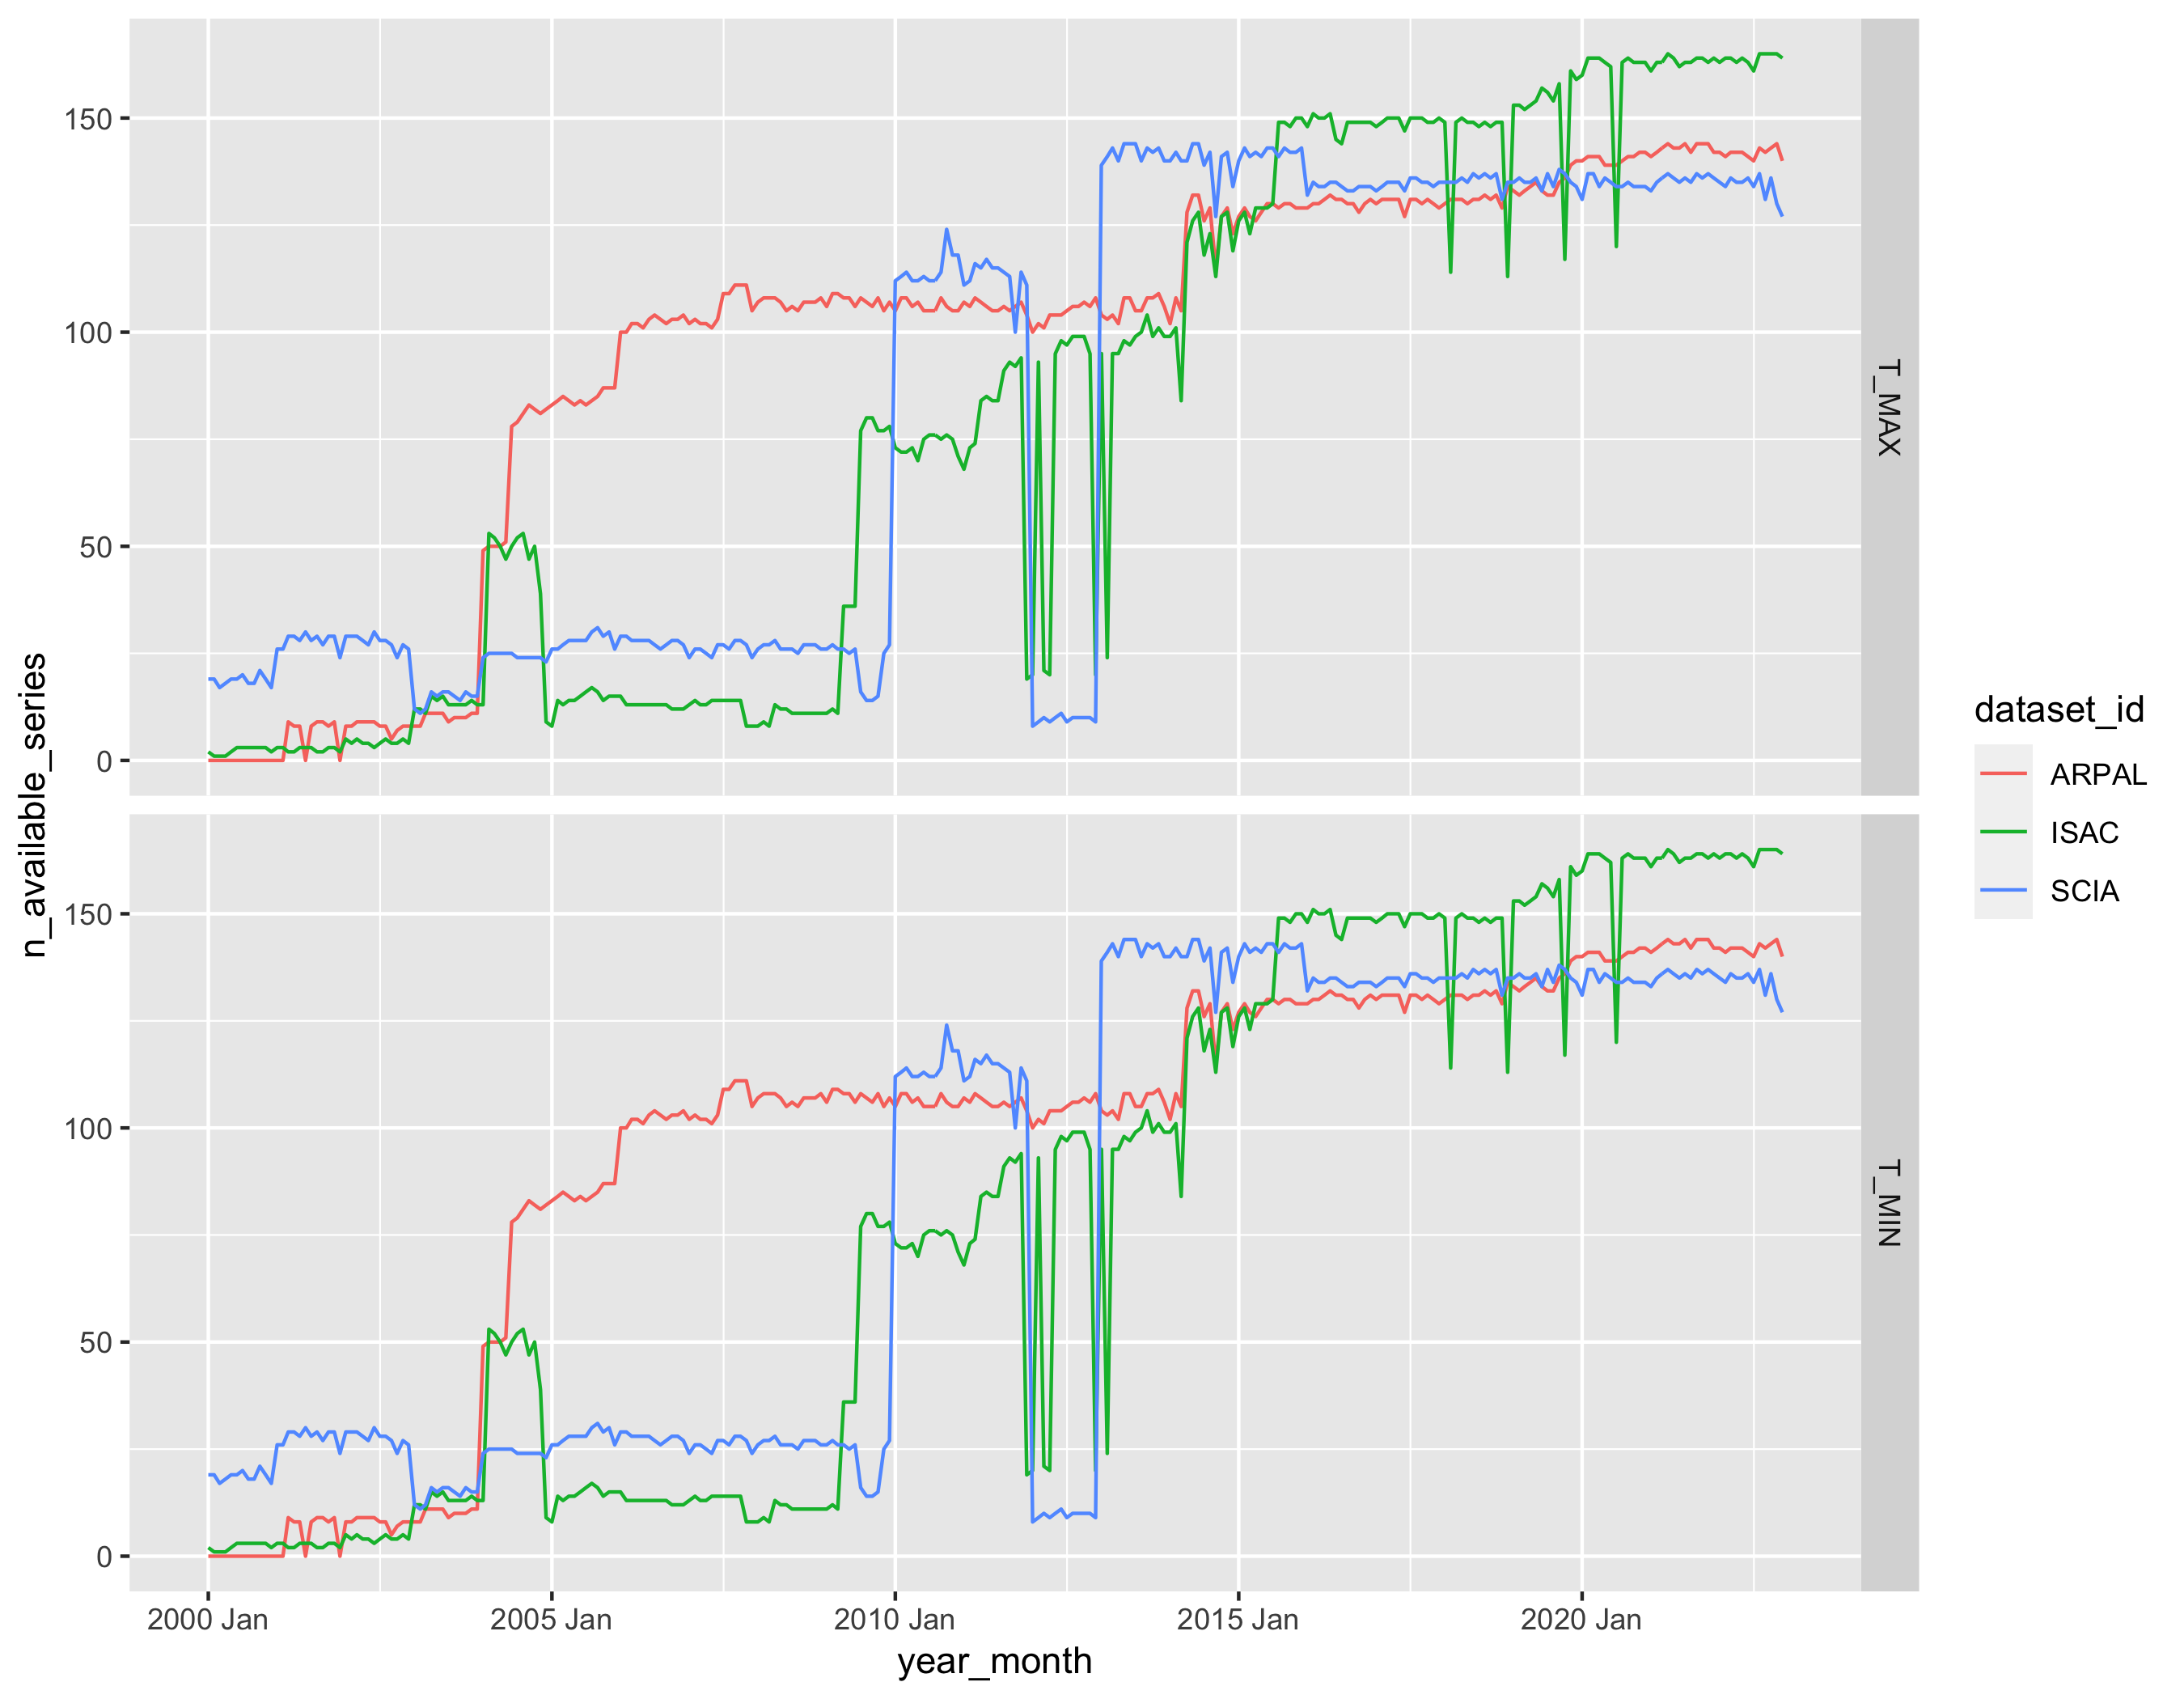

In [80]:
qc_database <- open_checkpoint(dataset_id, "qc1")
others <- concat_databases(
    open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries),
    open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries)
)
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = others,
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


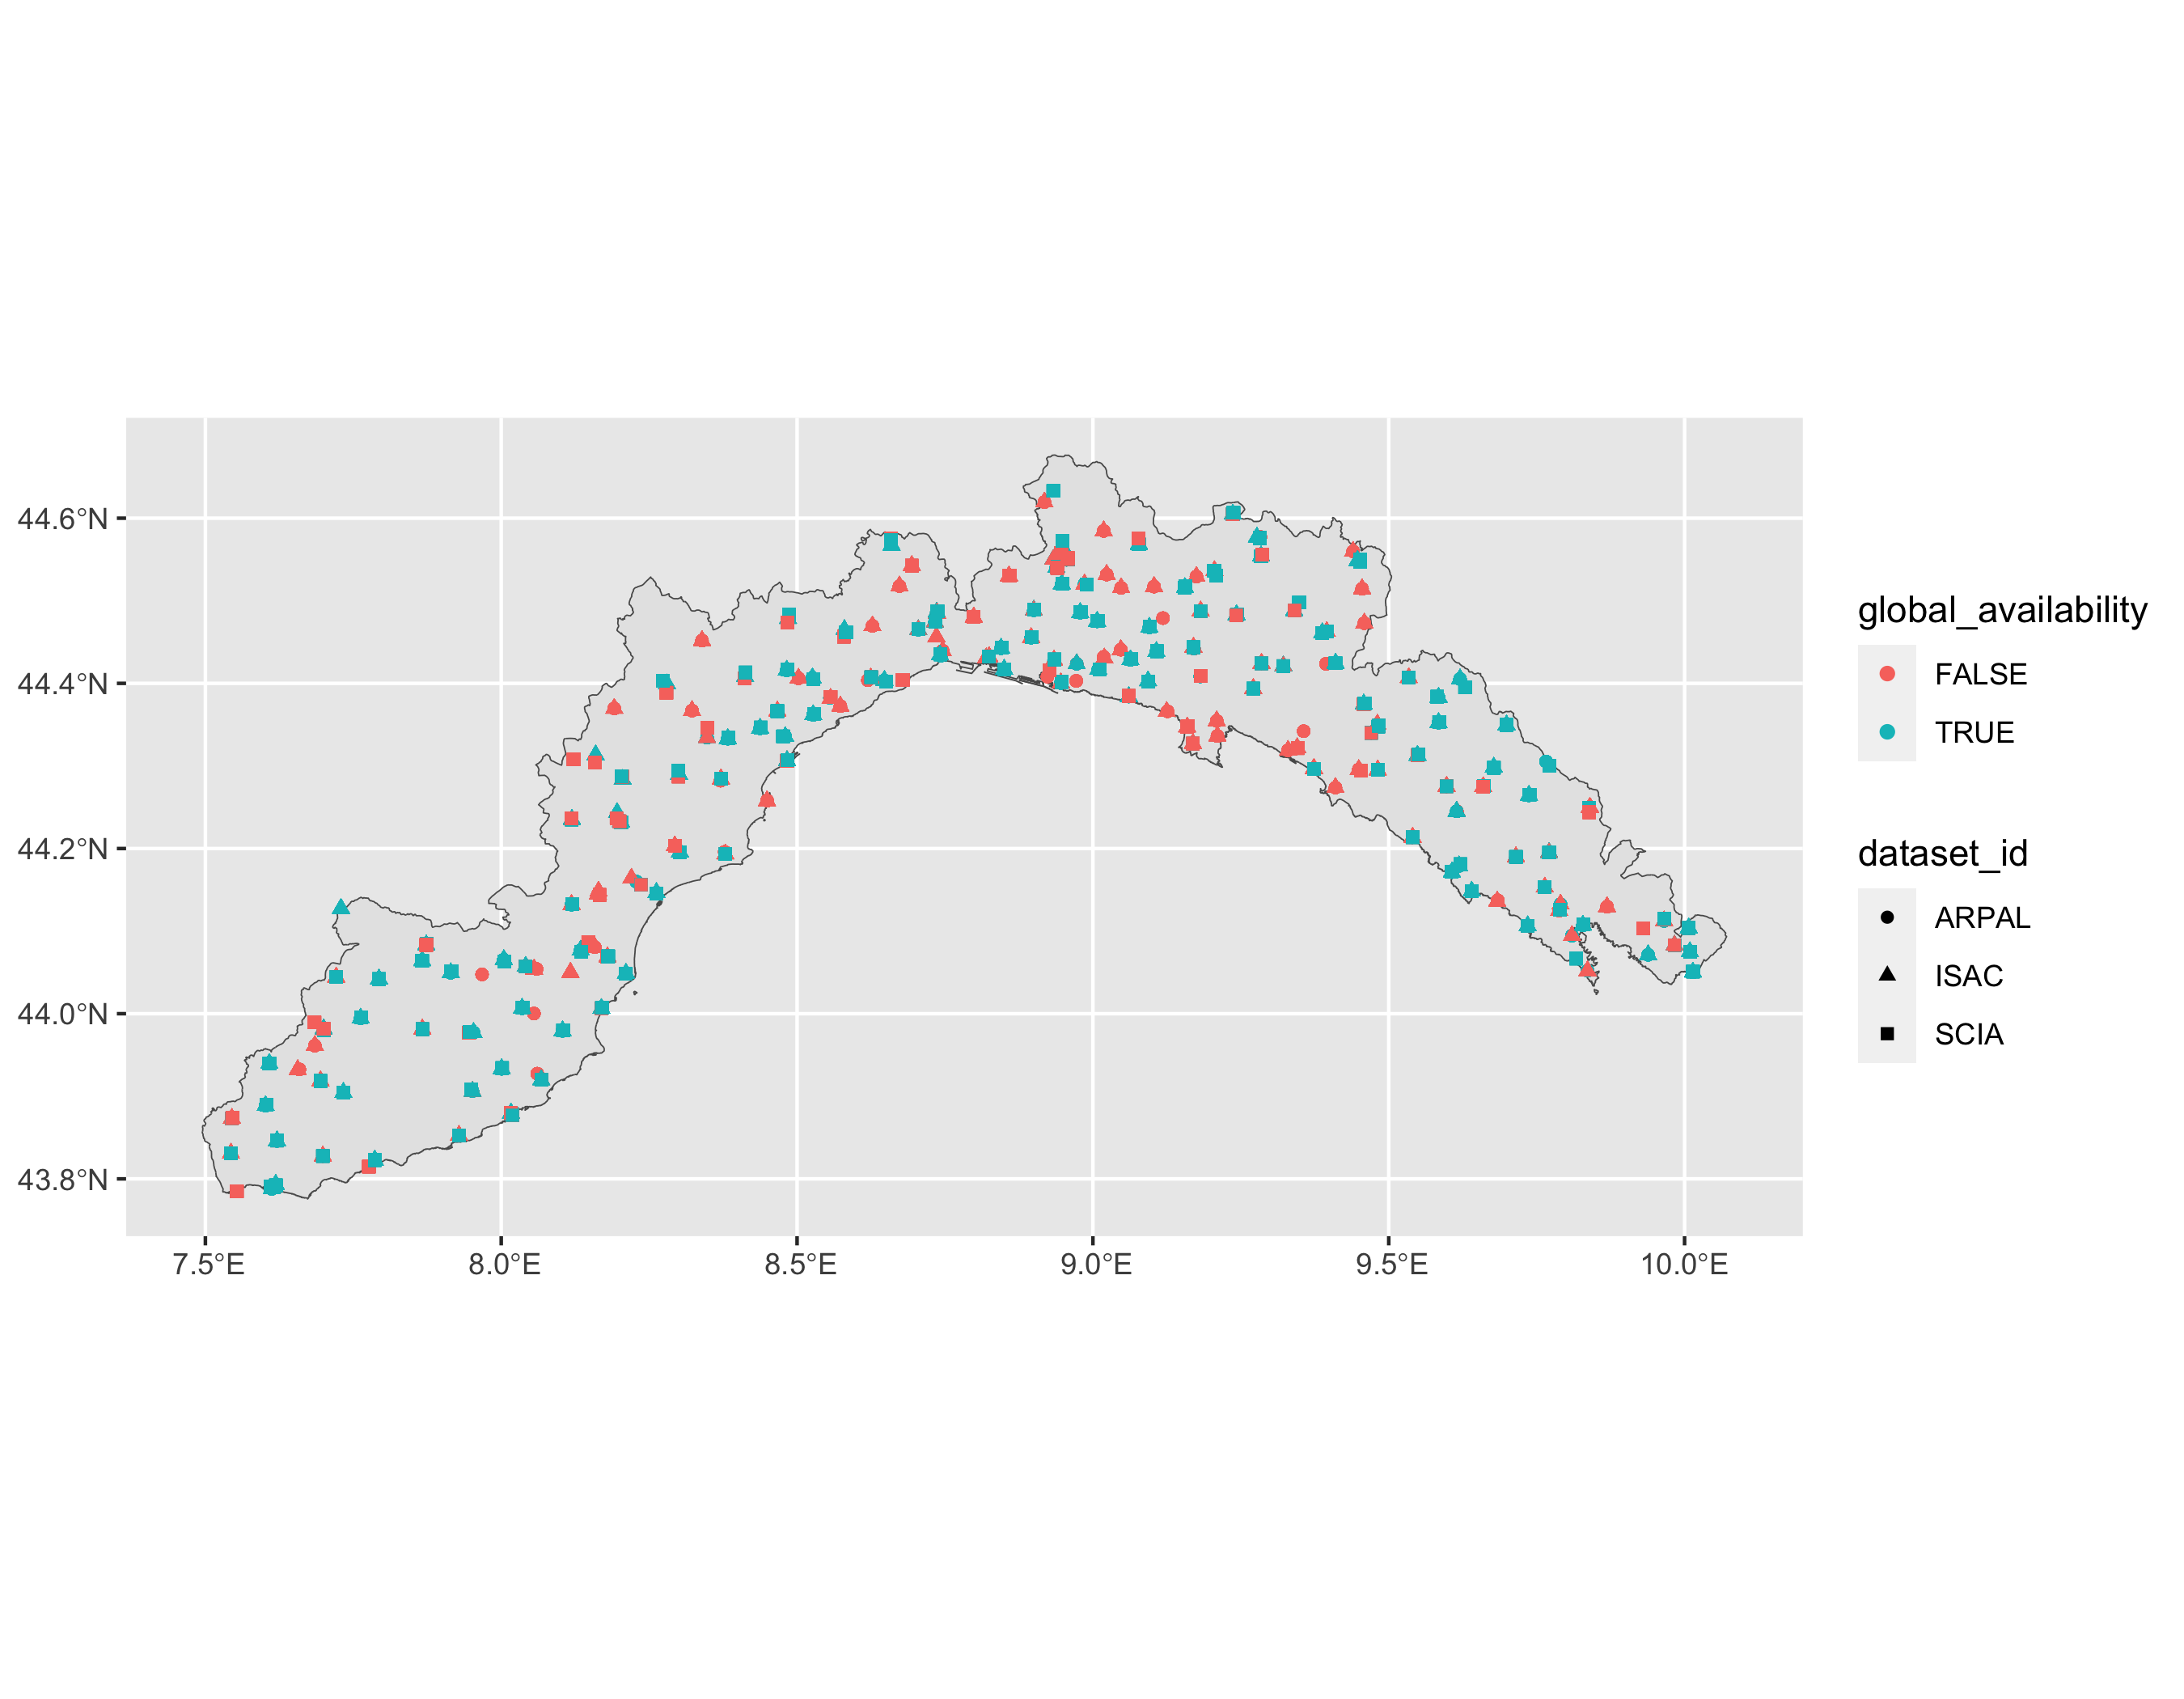

In [81]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, concat_tables(qc_database$meta, others$meta), state_boundaries)
p


In [62]:
rm(qc_database)
rm(others)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2281458,121.9,5704290,304.7,NA,7130362,380.9
Vcells,5884637,44.9,214298791,1635.0,16384,267871338,2043.7


## Merging
Gap-filling con SCIA. Giusto per integrare le poche registrazioni che ci sono tra il 2000 e il 2004.

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

#### Merge interno
Effettuo un merge interno al dataset. Non molto utile, a dire il vero

In [97]:
qc_state <- open_checkpoint(dataset_id, "qc1")
filtering_info <- qc_state$data |>
    group_by(station_id) |>
    summarise(last_date = max(date), .groups = "drop") |>
    collect()
merge_on_if <- function(meta_pair) {
    new_pairlist <- meta_pair |>
        left_join(filtering_info, join_by(station_id.x == station_id)) |>
        left_join(filtering_info, join_by(station_id.y == station_id)) |>
        filter(last_date.x >= last_date.y)
}

analysis_results <- perform_analysis_single(
    qc_state,
    dist_km = 2,
    first_date,
    last_date,
    analysis_file = file.path(str_to_lower(state), "state.xlsx"),
    merge_on_if
)
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_internal, "unusable" = tag_unusable_internal))
combination_results <- build_combined_database(analysis_results)
checkpoint_database(combination_results$database, dataset_id, "internal_merge")
save_match_list(combination_results$match_list, dataset_id, "internal_merge")
rm(qc_state)
rm(analysis_results)
rm(combination_results)
gc()

Data prepared. Launching analysis...

In [109]:
qc_state <- open_checkpoint(dataset_id, "internal_merge")
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_scia,
    dist_km = 4,
    first_date,
    last_date,
    str_to_lower(state),
)

rm(qc_state)
rm(qc_scia)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2425146,129.6,5704290,304.7,NA,7130362,380.9
Vcells,13097251,100.0,183817229,1402.5,16384,304801856,2325.5


In [110]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_vsscia, "unusable" = tag_unusable_vsscia))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,154
FALSE,TRUE,288
TRUE,FALSE,306


station_id.x,n
<chr>,<int>
12286ee04420375d31974cb34148d07d,4
41af8e3342638fbe7c9e4a376ca29d23,4
53add23d56f9195c66ae09c6a3363fda,4
55878254189e3e7046846d98e673fb19,4
5792a07585057d7c7eb9f366886127e8,4
6cee1bee867b2dd311f29061cc9041ff,4
6d81d1fe40dd01ff6eea1d55ad43f56c,4
74be912a475da300184b5f827525852a,4
7937cbd46f0fa7f0233a945d623c0731,3


station_id.y,n
<chr>,<int>
3d63e517c74eda18077a31d7328053a3,1
3dbf4e2d99ac24a4af7b85df3af8d868,1
6c8e4d15e87342cb7bc43aa3391930c6,4
a996a787ba878abd5a3b7e36b93e4fc3,4


In [111]:
combination_results <- build_combined_database(analysis_results)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")


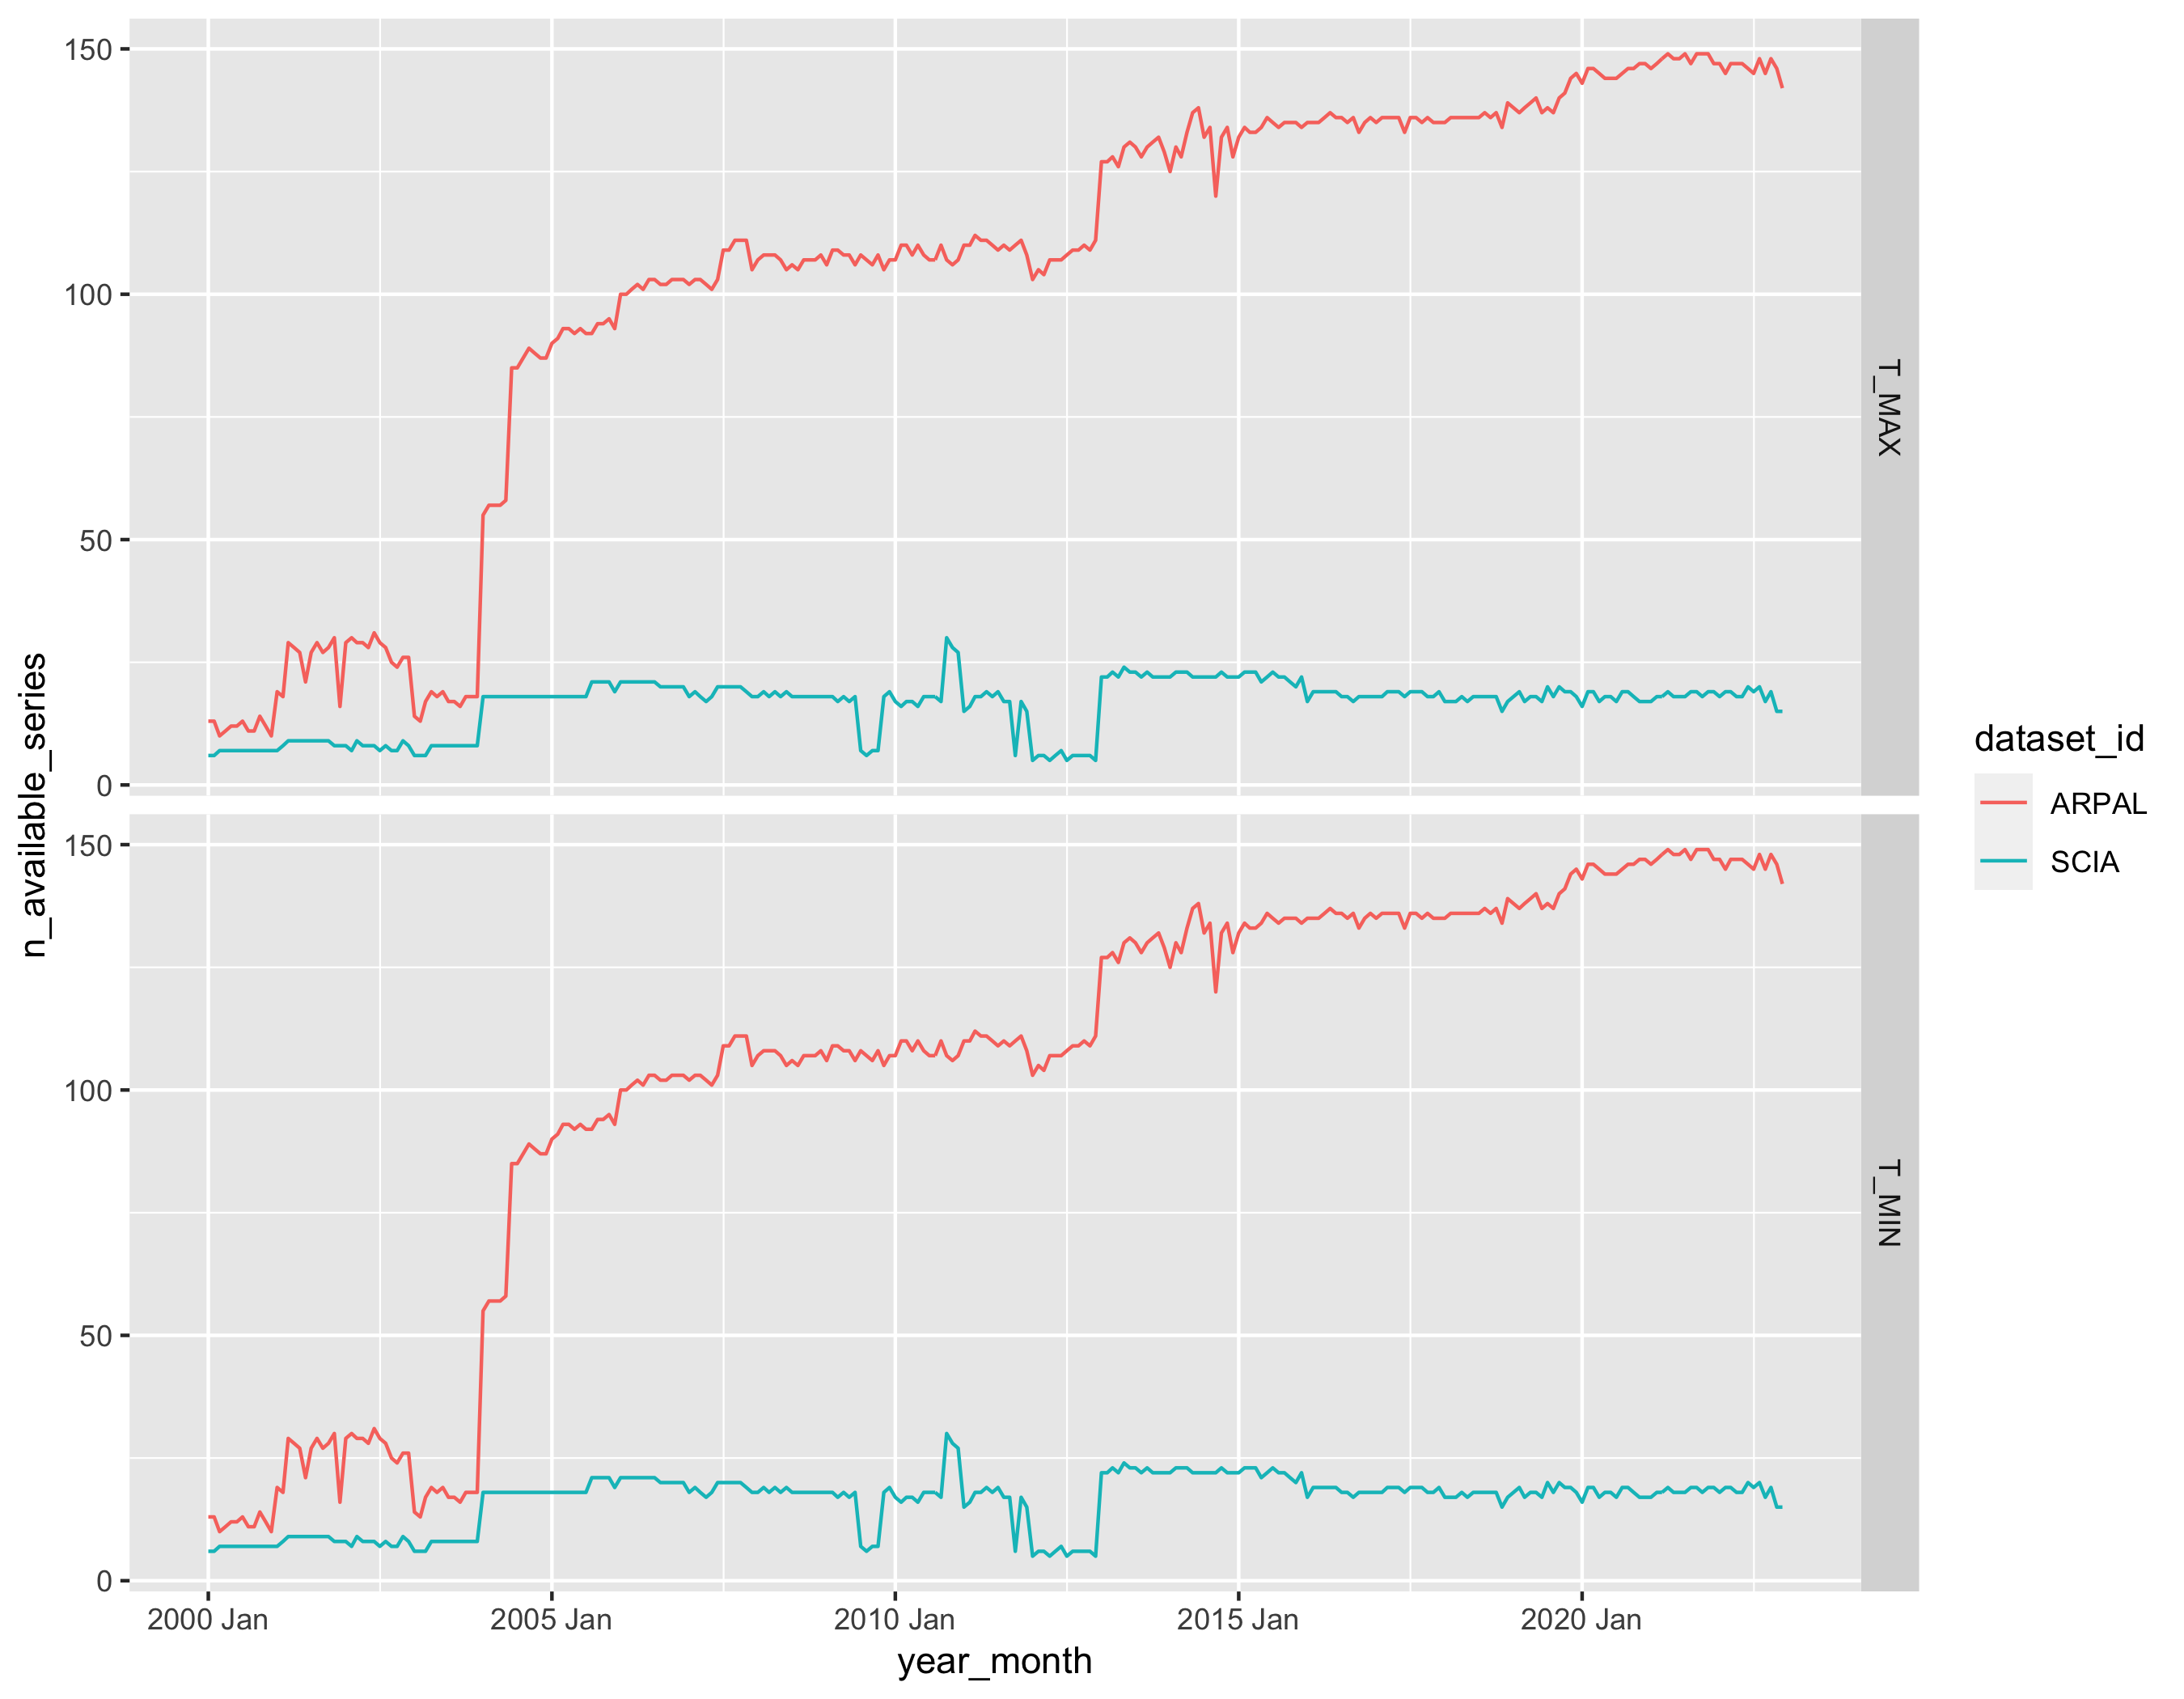

In [112]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


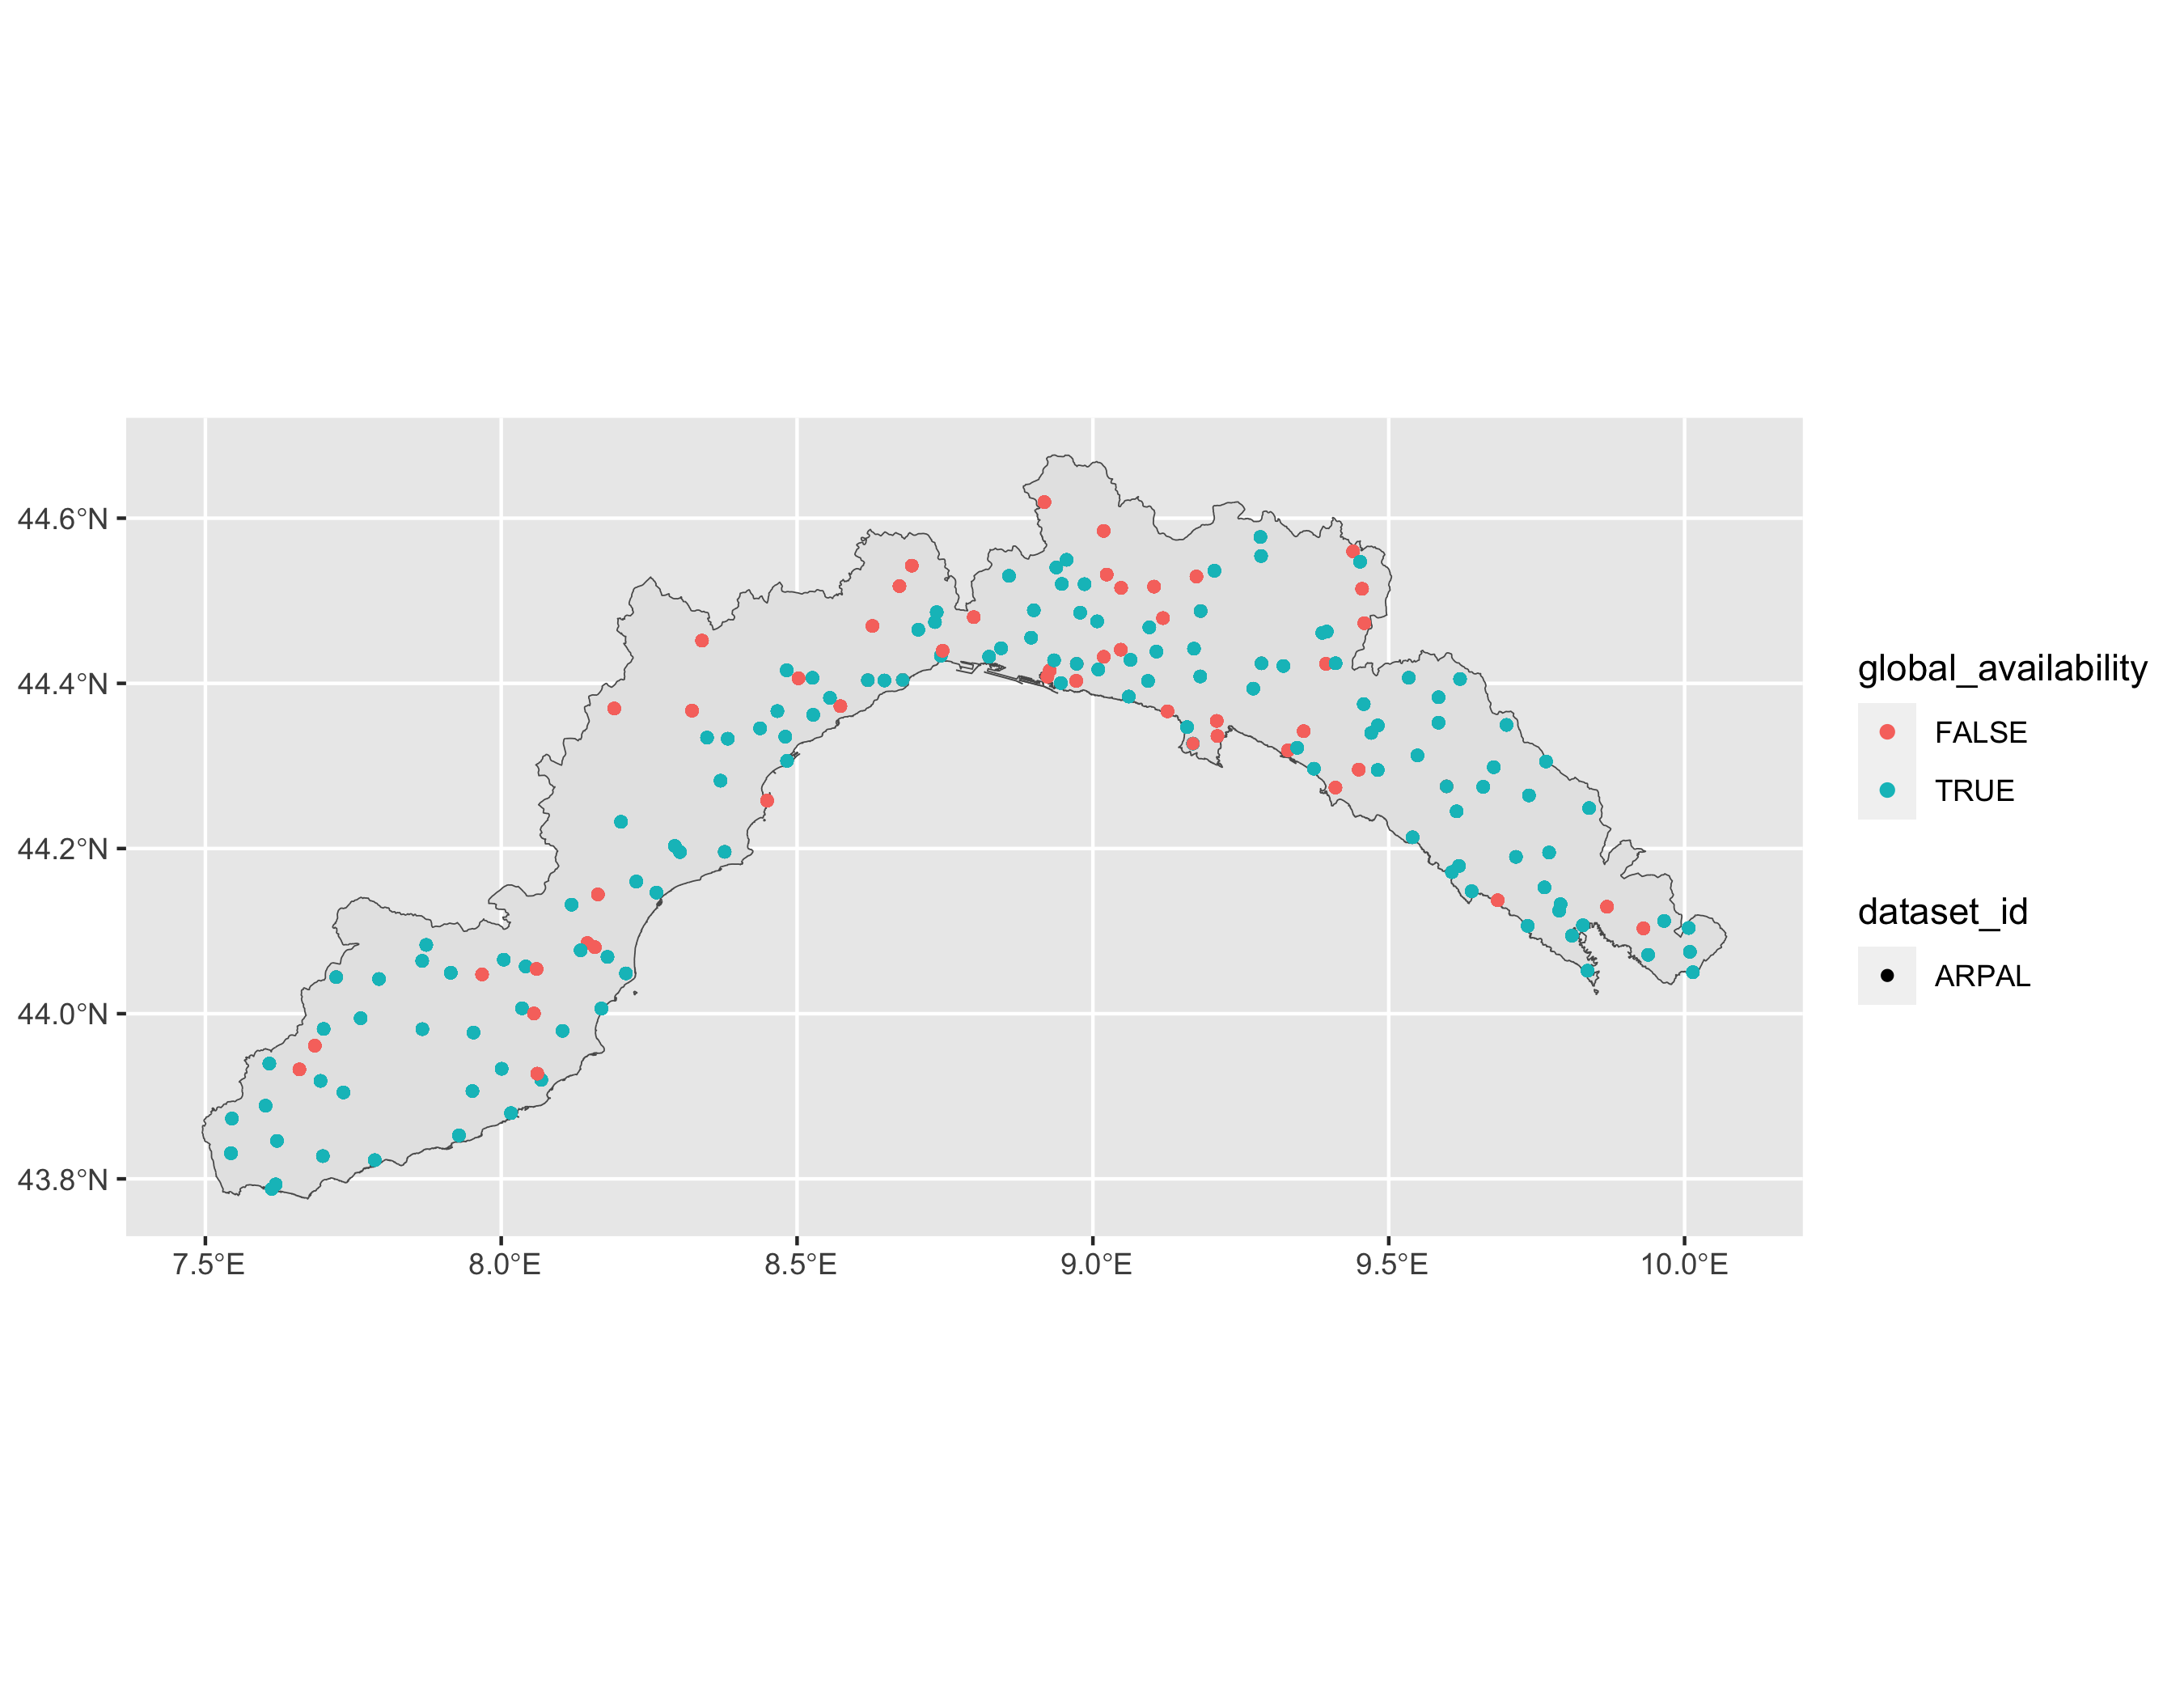

In [113]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), combined_database$meta, state_boundaries)
p


In [ ]:
rm(ymonthly_avail)
rm(climats)
gc()


In [115]:
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
open_checkpoint(dataset_id, "merged")$data |>
    distinct(station_id, variable) |>
    compute() |>
    nrow()


[1] 438

In [ ]:
# Lanciare da terminale
source("src/load/ITA.R")
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == "Liguria")
open_checkpoint("ARPAL", "merged") |>
    launch_leaflet()
